<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/ODE/Explained_Neural_Ordinary_Differential_Equations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

thanks: https://github.com/msurtsukov/neural-ode/blob/master/Neural%20ODEs.ipynb

Imagine a problem: there is a process following an unknown ODE and some (noisy) observations along its trajectory
$$
\begin{gathered}
\frac{d z}{d t}=f(z(t), t) \\
\left\{\left(z_{0}, t_{0}\right),\left(z_{1}, t_{1}\right), \ldots,\left(z_{M}, t_{M}\right)\right\}-\text { observations }
\end{gathered}
$$
Is it possible to find an approximation $\widehat{f}(z, t, \theta)$ of dynamics function $f(z, t)$ ?


First, consider a somewhat simpler task: there are only 2 observations, at the beginning and at the end of the trajectory, $\left(z_{0}, t_{0}\right),\left(z_{1}, t_{1}\right)$. One starts the evolution of the system from $z_{0}, t_{0}$ for time $t_{1}-t_{0}$ with some parameterized dynamics function using any ODE initial value solver. After that, one ends up being at some new state $\hat{z_{1}}, t_{1}$, compares it with the observation $z_{1}$, and tries to minimize the difference by varying the parameters $\theta$.

$$
L\left(z\left(t_{1}\right)\right)=L\left(\int_{t_{0}}^{t_{1}} f(z(t), t, \theta) d t\right)=L\left(\operatorname{ODESolve}\left(z\left(t_{0}\right), f, t_{0}, t_{1}, \theta\right)\right)
$$

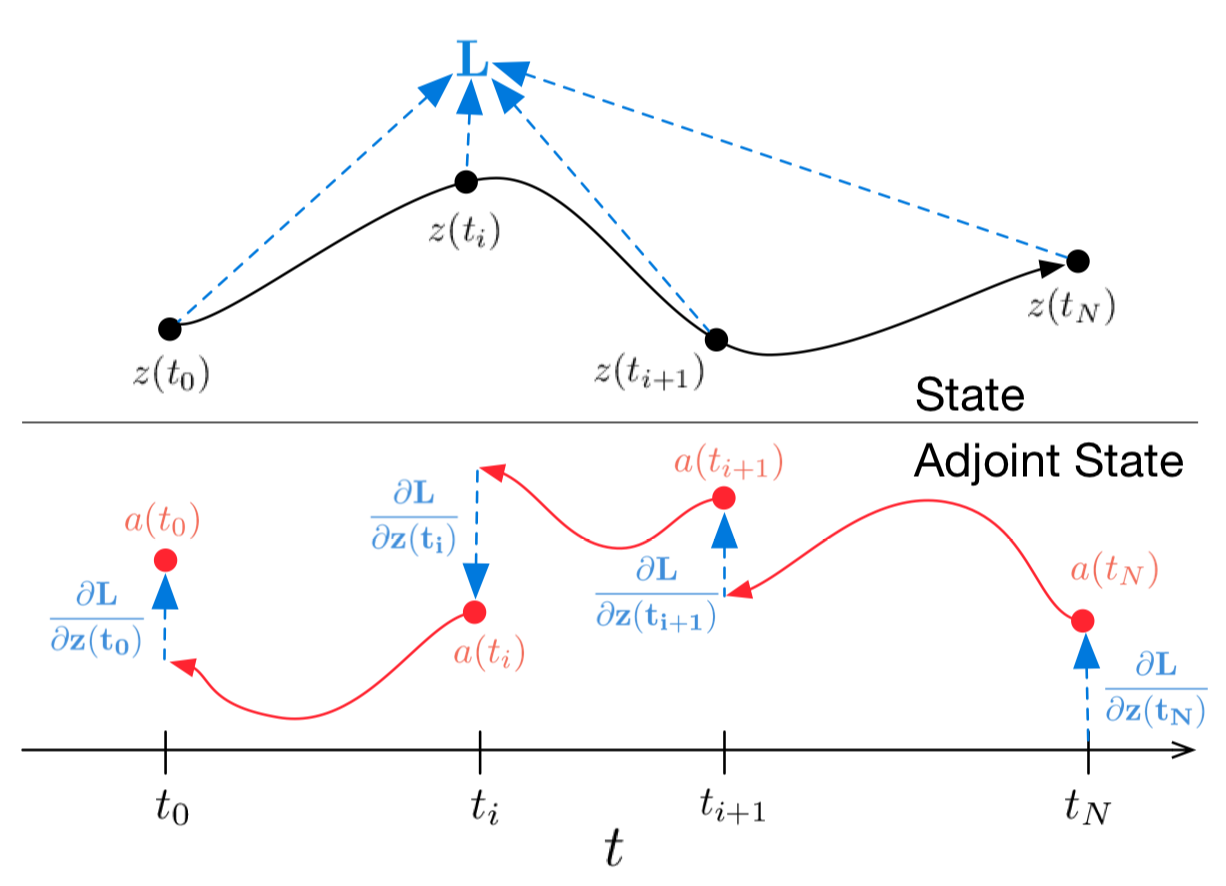

To optimize $L$ one needs to compute the gradients wrt. its parameters: $z\left(t_{0}\right), t_{0}, t_{1}, \theta$. To do this let us first determine how loss depends on the state at every moment of time $(z(t))$ :

$a(t)$ is called ***adjoint*** its dynamics is given by another ODE, which can be thought of as an instantaneous analog of the chain rule

$$
\frac{\partial L}{\partial z\left(t_{0}\right)}=\int_{t 1}^{t_{0}} a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} d t
$$


To compute the gradients wrt. to $t$ and $\theta$ one can think of them as if they were part of the augmented state

$$
\frac{d}{d t}\left[\begin{array}{l}
z \\
\theta \\
t
\end{array}\right](t)=f_{\mathrm{aug}}([z, \theta, t]):=\left[\begin{array}{c}
f([z, \theta, t]) \\
0 \\
1
\end{array}\right]
$$

Adjoint state to this augmented state is then


$$
a_{\mathrm{aug}}:=\left[\begin{array}{c}
a \\
a_{\theta} \\
a_{t}
\end{array}\right], a_{\theta}(t):=\frac{\partial L}{\partial \theta(t)}, a_{t}(t):=\frac{\partial L}{\partial t(t)}
$$

Gradient of the augmented dynamics


$$
\frac{\partial f_{\mathrm{aug}}}{\partial[z, \theta, t]}=\left[\begin{array}{ccc}
\frac{\partial f}{\partial z} & \frac{\partial f}{\partial \theta} & \frac{\partial f}{\partial t} \\
0 & 0 & 0 \\
0 & 0 & 0
\end{array}\right]
$$

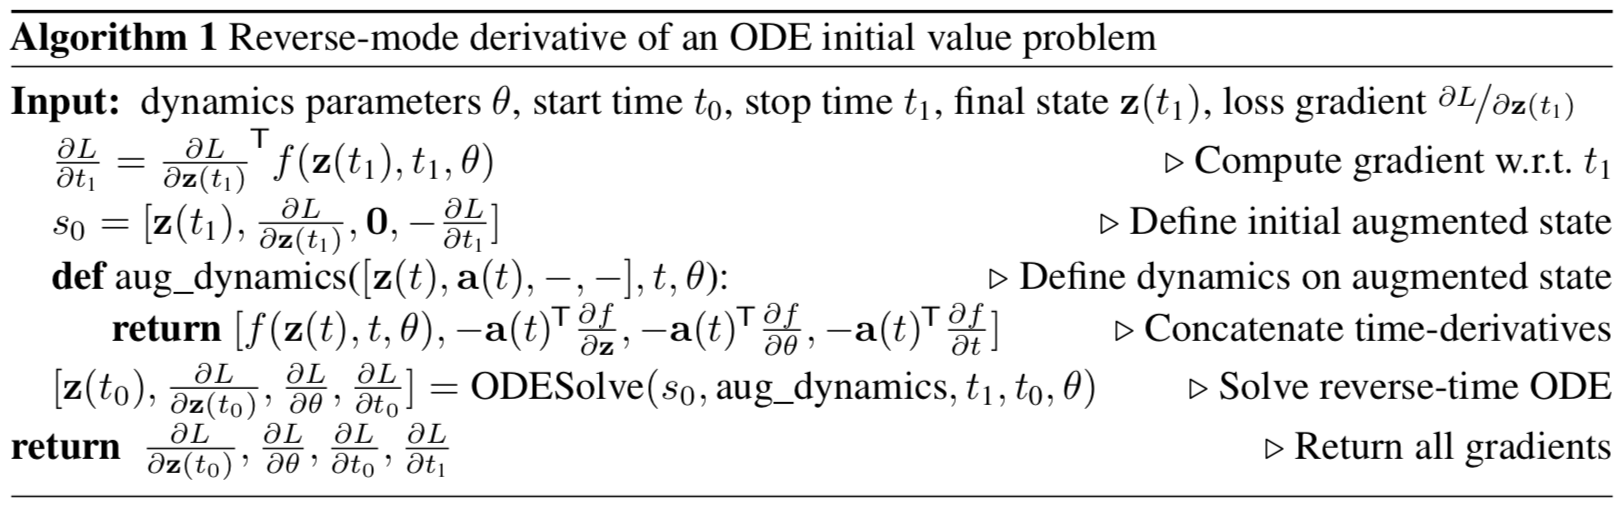


# Implementation

source: https://github.com/msurtsukov/neural-ode/blob/master/Neural%20ODEs.ipynb

In [3]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import matplotlib as matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.cm as com
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

Implement any ordinary differential equation initial value solver. For the sake of simplicity it'll be Euler's ODE initial value solver, however any explicit or implicit method will do.

In [4]:
def ode_solve(z0,t0,t1,f):
  """
  Simplest Euler ODE initial value solver
  """
  h_max = 0.05
  n_steps = math.ceil((abs(t1-t0)/h_max).max().item())

  h = (t1 - t0) / n_steps
  t = t0
  z = z0

  for i_step in range(n_steps):
    z = z + h * f(z, t)
    t = t + h
  return z

We also implement a superclass of parameterized dynamics function in the form of neural network with a couple useful methods.

First, one needs to be able to flatten all the parameters that the function depends on.

Second, one needs to implement a method that computes the augmented dynamics. This augmented dynamics depends on the gradient of the function wrt. its inputs and parameters. In order to not have to specify them by hand for every new architecture, we will use torch.autograd.grad method.

In [5]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)
    


The code below incapsulates forward and backward passes of Neural ODE. We have to separate it from main torch.nn.Module because custom backward function **can't be implemented inside Module**, but can be implemented inside torch.autograd.Function. So this is just a little workaround.

In [6]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    #func: dynamics function
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None       

In [7]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

# Application
## Learning true dynamics function (proof of concept)
As a proof-of-concept we will now test if Neural ODE can indeed restore true dynamics function using sampled data.

To test this we will specify an ODE, evolve it and sample points on its trajectory, and then restore it.

First, we'll test a simple linear ODE. Dynamics is given with a matrix.
$$
\frac{d z}{d t}=\left[\begin{array}{cc}
-0.1 & -1.0 \\
1.0 & -0.1
\end{array}\right] z
$$


In [12]:
class LinearODEF(ODEF):
  def __init__(self,W):
    super(LinearODEF,self).__init__()
    self.lin = nn.Linear(2,2,bias=False)
    self.lin.weight = nn.Parameter(W)
  
  def forward(self, x, t):
    return self.lin(x)

In [43]:
ts_ = torch.as_tensor(np.array([[-0.1,-1.0],[1.0,-0.1]]),dtype=torch.float)
ts_


tensor([[-0.1000, -1.0000],
        [ 1.0000, -0.1000]])

In [13]:
#Dynamics is simply given with a matrix.

class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))

In [14]:
#Initial random linear dynamics function to be optimized

class RandomLinearODEF(LinearODEF):
  def __init__(self):
    super(RandomLinearODEF,self).__init__(torch.randn(2,2)/2.)

In [15]:
#More sophisticated dynamics for creating trajectories

class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

In [16]:
#Dynamics function to be optimized is MLP

class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [17]:
def to_np(x):
  return x.detach().cpu().numpy()

In [18]:
import matplotlib.cm as cm
def plot_trajectories(obs=None, times=None, trajs=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        #if save is not None:
            #plt.savefig(save)
    plt.show()

In [19]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan 
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_
    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(obs=[obs], times=[times], trajs=[z_p])
            clear_output(wait=True)


In [45]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

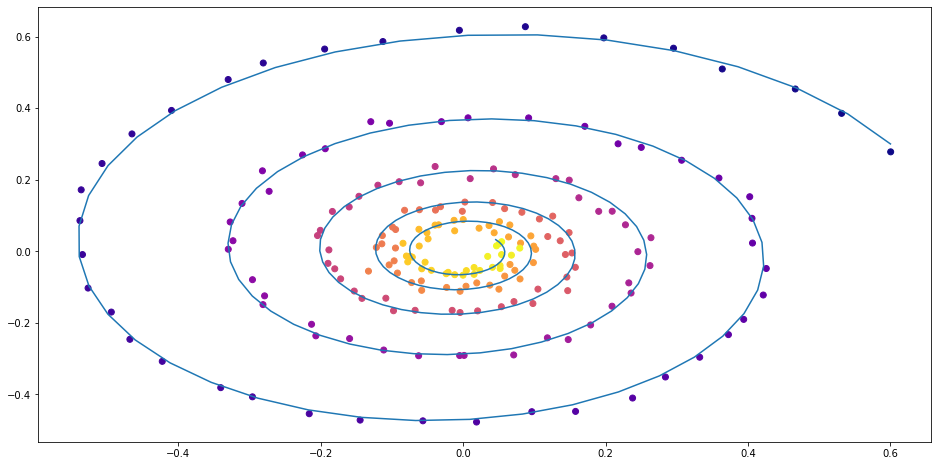

In [47]:
conduct_experiment(ode_true, ode_trained, 500, "linear")

As one can see, Neural ODEs are pretty successful in approximating dynamics. Now let's check if they can be used in a slightly more complicated (MNIST, ha-ha) task.


Neural ODE inspired by ResNets
In residual networks hidden state changes according to the formula
$$
h_{t+1}=h_{t}+f\left(h_{t}, \theta_{t}\right)
$$
where $t \in\{0 \ldots T\}$ is residual block number and $f$ is a function learned by layers inside the block.

If one takes a limit of an infinite number of residual blocks with smaller steps one gets continuous dynamics of hidden units to be an ordinary differential equation just as we had above.
$$
\frac{d h(t)}{d t}=f(h(t), t, \theta)
$$
Starting from the input layer $h(0)$, one can define the output layer $h(T)$ to be the solution to this ODE initial value problem at some time $T$.

Now one can treat $\theta$ as parameters shared among all infinitesimally small residual blocks.

In [59]:
from torch.nn.modules import padding
def norm(dim):
    return nn.BatchNorm2d(dim)

def conv3x3(in_feats, out_feats, stride=1):
    return nn.Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)

def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)


In [51]:
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)
    #parameters t
    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

In [54]:
class ContinuousNeuralMNISTClassifier(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeuralMNISTClassifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode #here ODE
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out


In [60]:
func = ConvODEF(64) #dim = 64
ode = NeuralODE(func) #zt
model = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model = model.cuda()

In [55]:
import torchvision

img_std = 0.3081
img_mean = 0.1307


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=128, shuffle=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [61]:
optimizer = torch.optim.Adam(model.parameters())

In [63]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [64]:
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [65]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 9.830%
Training Epoch 1...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.16651
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.620%
Training Epoch 2...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.05082
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.050%
Training Epoch 3...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03798
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.980%
Training Epoch 4...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03049
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.090%
Training Epoch 5...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.02345
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.090%


Testing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.090%
Training Epoch 1...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.02137
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.990%
Training Epoch 2...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.01673
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.280%
Training Epoch 3...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.01533
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.120%
Training Epoch 4...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.01373
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.810%
Training Epoch 5...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.01114
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.020%


<Figure size 648x360 with 0 Axes>

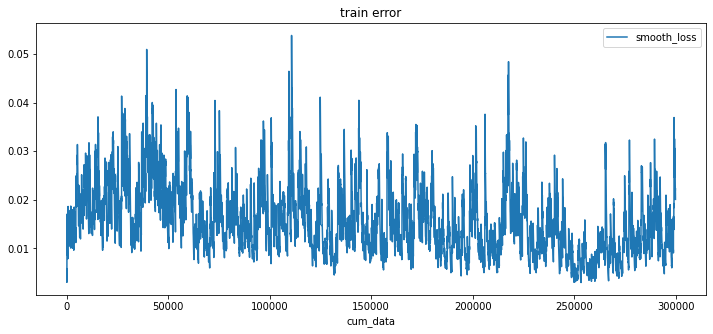

In [66]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()
import pandas as pd

plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * batch_size
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="train error")

# Generative latent function time-series model

Neural ODE seems to be more suitable for continuous sequential data even when this continuous trajectory is in some unknown latent space.

In this section we will experiment with generating continuous sequential data using Neural ODE and exploring its latent space a bit. Authors also compare it to the same sequential data but generated with Recurrent Neural Networks.

The approach here is slightly different from the corresponding example in authors repository, the one here has a more diverse set of trajectories.

## Data
Training data consists of random spirals, one half of which is clockwise and another is counter-clockwise. Then, random subtimespans of size 100 are sampled from these spirals, having passed through encoder rnn model in reversed order yielding a latent starting state, which then evolves creating a trajectory in the latent space. This latent trajectory is then mapped onto the data space trajectory and compared with the actual data observations. Thus, the model learns to generate data-alike trajectories.


## VAE as a generative model
A generative model through sampling procedure:
$$
\begin{gathered}
z_{t_{0}} \sim \mathcal{N}(0, I) \\
z_{t_{1}}, z_{t_{2}}, \ldots, z_{t_{M}}=\operatorname{ODESolve}\left(z_{t_{0}}, f, \theta_{f}, t_{0}, \ldots, t_{M}\right) \\
\text { each } x_{t_{i}} \sim p\left(x \mid z_{t_{i}} ; \theta_{x}\right)
\end{gathered}
$$
Which can be trained using variational autoencoder approach:
1. Run the RNN encoder through the time series backwards in time to infer the parameters $\mu_{z_{0^{\prime}}} \sigma_{z_{t_{0}}}$ of variational posterior and sample from it
$$
z_{t_{0}} \sim q\left(z_{t_{0}} \mid x_{t_{0}}, \ldots, x_{t_{M}} ; t_{0}, \ldots, t_{M} ; \theta_{q}\right)=\mathcal{N}\left(z_{t_{0}} \mid \mu_{z_{0}} \sigma_{z t_{0}}\right)
$$

2. Obtain the latent trajectory
$$
z_{t_{1}}, z_{t_{2}}, \ldots, z_{t_{N}}=\operatorname{ODESolve}\left(z_{t_{0}}, f, \theta_{f}, t_{0}, \ldots, t_{N}\right), \text { where } \frac{d z}{d t}=f\left(z, t ; \theta_{f}\right)
$$
3. Map the latent trajectory onto the data space using another neural network: $\hat{x_{t}}\left(z_{t_{i}}, t_{i} ; \theta_{x}\right)$
4. Maximize Evidence Lower BOund estimate for sampled trajectory
$$
\mathrm{ELBO} \approx N\left(\sum_{i=0}^{M} \log p\left(x_{t_{i}} \mid z_{t_{i}}\left(z_{t_{0}} ; \theta_{f}\right) ; \theta_{x}\right)+K L\left(q\left(z_{t_{0}} \mid x_{t_{0}}, \ldots, x_{t_{M}}+t_{0}, \ldots, t_{M} ; \theta_{q}\right) \|\right.\right.
$$
And in case of Gaussian posterior $p\left(x \mid z_{t_{i}} ; \theta_{x}\right)$ and known noise level $\sigma_{x}$
$$
\mathrm{ELBO} \approx-N\left(\sum_{i=1}^{M} \frac{\left(x_{i}-\hat{x_{i}}\right)^{2}}{\sigma_{x}^{2}}-\log \sigma_{z t_{0}}^{2}+\mu_{z t_{0}}^{2}+\sigma_{z t_{0}}^{2}\right)+C
$$


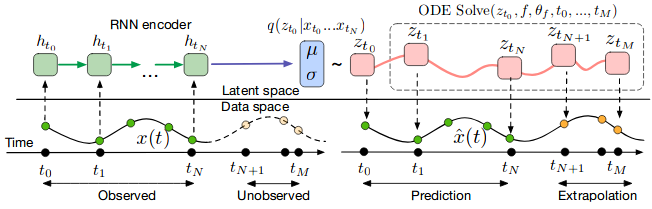

In [8]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(RNNEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.rnn = nn.GRU(input_dim+1, hidden_dim)
        self.hid2lat = nn.Linear(hidden_dim, 2*latent_dim)

    def forward(self, x, t):
        # Concatenate time to input
        t = t.clone()
        t[1:] = t[:-1] - t[1:]
        t[0] = 0.
        xt = torch.cat((x, t), dim=-1)

        _, h0 = self.rnn(xt.flip((0,)))  # Reversed
        # Compute latent dimension
        z0 = self.hid2lat(h0[0])
        z0_mean = z0[:, :self.latent_dim]
        z0_log_var = z0[:, self.latent_dim:]
        return z0_mean, z0_log_var

In [9]:
class NeuralODEDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(NeuralODEDecoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        func = NNODEF(latent_dim, hidden_dim, time_invariant=True)
        self.ode = NeuralODE(func)
        self.l2h = nn.Linear(latent_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, output_dim)

    def forward(self, z0, t):
        zs = self.ode(z0, t, return_whole_sequence=True)

        hs = self.l2h(zs)
        xs = self.h2o(hs)
        return xs

In [10]:
class ODEVAE(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(ODEVAE, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = RNNEncoder(output_dim, hidden_dim, latent_dim)
        self.decoder = NeuralODEDecoder(output_dim, hidden_dim, latent_dim)

    def forward(self, x, t, MAP=False):
        z_mean, z_log_var = self.encoder(x, t)
        if MAP:
            z = z_mean
        else:
            z = z_mean + torch.randn_like(z_mean) * torch.exp(0.5 * z_log_var)
        x_p = self.decoder(z, t)
        return x_p, z, z_mean, z_log_var

    def generate_with_seed(self, seed_x, t):
        seed_t_len = seed_x.shape[0]
        z_mean, z_log_var = self.encoder(seed_x, t[:seed_t_len])
        x_p = self.decoder(z_mean, t)
        return x_p

In [20]:
#Generating dataset

t_max = 6.29*5
n_points = 200
noise_std = 0.02

num_spirals = 1000

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]] * num_spirals)
times = torch.from_numpy(times_np[:, :, None]).to(torch.float32)

# Generate random spirals parameters
normal01 = torch.distributions.Normal(0, 1.0)

x0 = Variable(normal01.sample((num_spirals, 2))) * 2.0  

W11 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W22 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W21 = -1.0 * normal01.sample((num_spirals,)).abs()
W12 =  1.0 * normal01.sample((num_spirals,)).abs()

xs_list = []
for i in range(num_spirals):
    if i % 2 == 1: #  Make it counter-clockwise
        W21, W12 = W12, W21

    func = LinearODEF(Tensor([[W11[i], W12[i]], [W21[i], W22[i]]]))
    ode = NeuralODE(func)

    xs = ode(x0[i:i+1], times[:, i:i+1], return_whole_sequence=True)
    xs_list.append(xs)


orig_trajs = torch.cat(xs_list, dim=1).detach()
samp_trajs = orig_trajs + torch.randn_like(orig_trajs) * noise_std
samp_ts = times

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


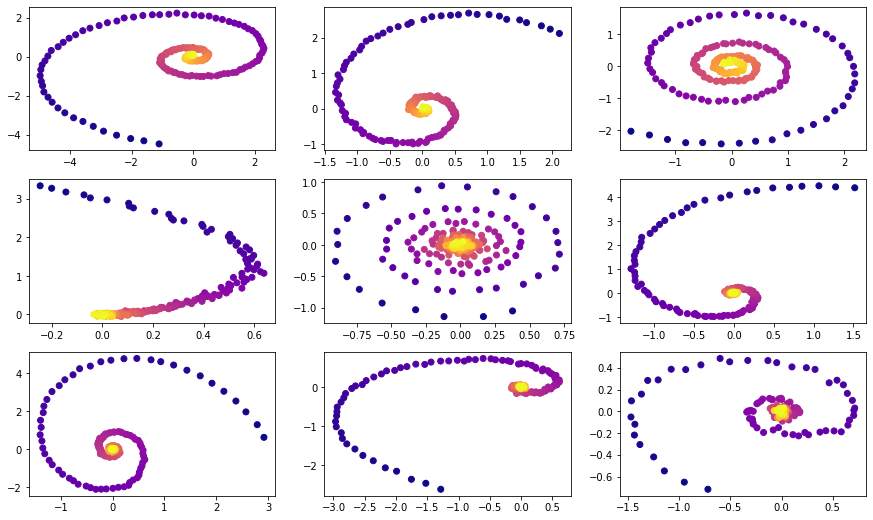

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.scatter(samp_trajs[:, i, 0], samp_trajs[:, i, 1], c=samp_ts[:, i, 0], cmap=cm.plasma)
plt.show()

In [22]:
import numpy.random as npr

def gen_batch(batch_size, n_sample=100):
    n_batches = samp_trajs.shape[1] // batch_size
    time_len = samp_trajs.shape[0]
    n_sample = min(n_sample, time_len)
    for i in range(n_batches):
        if n_sample > 0:
            t0_idx = npr.multinomial(1, [1. / (time_len - n_sample)] * (time_len - n_sample))
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_sample
        else:
            t0_idx = 0
            tM_idx = time_len

        frm, to = batch_size*i, batch_size*(i+1)
        yield samp_trajs[t0_idx:tM_idx, frm:to], samp_ts[t0_idx:tM_idx, frm:to]

### Training

In [23]:
vae = ODEVAE(2, 64, 6)
vae = vae.cuda()
if use_cuda:
    vae = vae.cuda()

In [24]:
optim = torch.optim.Adam(vae.parameters(), betas=(0.9, 0.999), lr=0.001)

In [25]:
preload = False
n_epochs = 20000
batch_size = 100

plot_traj_idx = 1
plot_traj = orig_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_obs = samp_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_ts = samp_ts[:, plot_traj_idx:plot_traj_idx+1]
if use_cuda:
    plot_traj = plot_traj.cuda()
    plot_obs = plot_obs.cuda()
    plot_ts = plot_ts.cuda()

if preload:
    vae.load_state_dict(torch.load("models/vae_spirals.sd"))

for epoch_idx in range(n_epochs):
    losses = []
    train_iter = gen_batch(batch_size)
    for x, t in train_iter:
        optim.zero_grad()
        if use_cuda:
            x, t = x.cuda(), t.cuda()

        max_len = np.random.choice([30, 50, 100])
        permutation = np.random.permutation(t.shape[0])
        np.random.shuffle(permutation)
        permutation = np.sort(permutation[:max_len])

        x, t = x[permutation], t[permutation]

        x_p, z, z_mean, z_log_var = vae(x, t)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), -1)
        loss = 0.5 * ((x-x_p)**2).sum(-1).sum(0) / noise_std**2 + kl_loss
        loss = torch.mean(loss)
        loss /= max_len
        loss.backward()
        optim.step()
        losses.append(loss.item())

    print(f"Epoch {epoch_idx}")

    frm, to, to_seed = 0, 200, 50
    seed_trajs = samp_trajs[frm:to_seed]
    ts = samp_ts[frm:to]
    if use_cuda:
        seed_trajs = seed_trajs.cuda()
        ts = ts.cuda()

    samp_trajs_p = to_np(vae.generate_with_seed(seed_trajs, ts))

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.scatter(to_np(seed_trajs[:, i, 0]), to_np(seed_trajs[:, i, 1]), c=to_np(ts[frm:to_seed, i, 0]), cmap=cm.plasma)
        ax.plot(to_np(orig_trajs[frm:to, i, 0]), to_np(orig_trajs[frm:to, i, 1]))
        ax.plot(samp_trajs_p[:, i, 0], samp_trajs_p[:, i, 1])
    plt.show()

    print(np.mean(losses), np.median(losses))
    clear_output(wait=True)

KeyboardInterrupt: ignored